<a href="https://colab.research.google.com/github/Oleksij-gh/PersonaFilmRecommender/blob/main/RecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Global parameters

In [2]:
seed = 42

to do:

Значения характера - категориальные признаки и прогнать через OHE

# Data

## Donload and Unzip

In [1]:
# Download data
!gdown 1moqyaSdqD0VWfv-MKAcaCAO7W2RewAQF

# Unzip data
import zipfile
with zipfile.ZipFile('/content/RecSys.zip') as zip:
    zip.extractall('/content/data')




Downloading...
From: https://drive.google.com/uc?id=1moqyaSdqD0VWfv-MKAcaCAO7W2RewAQF
To: /content/RecSys.zip
100% 9.92M/9.92M [00:00<00:00, 64.1MB/s]


## Preprocessing

In [3]:
import pandas as pd

In [4]:
person_data = pd.read_csv('/content/data/2018-personality-data.csv')
rating_data = pd.read_csv('/content/data/2018_ratings.csv')

In [5]:
person_data = person_data.drop([' assigned metric',
       ' assigned condition', ' movie_1', ' predicted_rating_1', ' movie_2',
       ' predicted_rating_2', ' movie_3', ' predicted_rating_3', ' movie_4',
       ' predicted_rating_4', ' movie_5', ' predicted_rating_5', ' movie_6',
       ' predicted_rating_6', ' movie_7', ' predicted_rating_7', ' movie_8',
       ' predicted_rating_8', ' movie_9', ' predicted_rating_9', ' movie_10',
       ' predicted_rating_10', ' movie_11', ' predicted_rating_11',
       ' movie_12', ' predicted_rating_12', ' is_personalized',
       ' enjoy_watching '], axis=1)

In [6]:
person_data

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion
0,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5
1,77c7d756a093150d4377720abeaeef76,7.0,4.0,6.0,5.5,4.0
2,b7e8a92987a530cc368719a0e60e26a3,4.0,3.0,4.5,2.0,2.5
3,92561f21446e017dd6b68b94b23ad5b7,5.5,5.5,4.0,4.5,4.0
4,030001ac2145a938b07e686a35a2d638,5.5,5.5,3.5,4.5,2.5
...,...,...,...,...,...,...
1829,cff910b71f09b3120289ff6b461a9e03,5.5,3.5,2.5,4.0,5.5
1830,1ab3a4c2921d8da640854819b0f6cfce,4.0,3.5,4.5,4.0,2.5
1831,a06386edadf3bc614dadb7044708c46c,6.0,3.0,5.5,3.5,6.0
1832,bad56d9506832cd79d874a6b66b3d813,5.0,3.5,1.5,3.5,2.5


In [7]:
rating_data = rating_data.rename({'useri': 'userid'}, axis=1)

In [8]:
rating_data.shape

(1028751, 4)

In [9]:
data = person_data.merge(rating_data, how="inner", on=['userid'])

In [10]:
data.shape

(1070203, 9)

In [11]:
person_data.head()

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion
0,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5
1,77c7d756a093150d4377720abeaeef76,7.0,4.0,6.0,5.5,4.0
2,b7e8a92987a530cc368719a0e60e26a3,4.0,3.0,4.5,2.0,2.5
3,92561f21446e017dd6b68b94b23ad5b7,5.5,5.5,4.0,4.5,4.0
4,030001ac2145a938b07e686a35a2d638,5.5,5.5,3.5,4.5,2.5


In [12]:
rating_data.head()

,userid,movie_id,rating,tstamp
0,8e7cebf9a234c064b75016249f2ac65e,1,5.0,2001-09-10 17:19:56
1,8e7cebf9a234c064b75016249f2ac65e,2,4.0,2001-09-28 11:34:55
2,8e7cebf9a234c064b75016249f2ac65e,3,4.0,2001-09-28 11:42:50
3,8e7cebf9a234c064b75016249f2ac65e,5,5.0,2001-09-28 11:27:30
4,8e7cebf9a234c064b75016249f2ac65e,6,4.0,2002-01-07 18:12:02


In [13]:
data = data.drop(['userid', ' tstamp '], axis=1)
data.head()

,openness,agreeableness,emotional_stability,conscientiousness,extraversion,movie_id,rating
0,5.0,2.0,3.0,2.5,6.5,1,5.0
1,5.0,2.0,3.0,2.5,6.5,2,4.0
2,5.0,2.0,3.0,2.5,6.5,3,4.0
3,5.0,2.0,3.0,2.5,6.5,5,5.0
4,5.0,2.0,3.0,2.5,6.5,6,4.0


In [14]:
data[' rating'].astype('int').value_counts()

 rating
3    416879
4    348024
2    158296
5     72821
1     52546
0     21637
Name: count, dtype: int64

<Axes: >

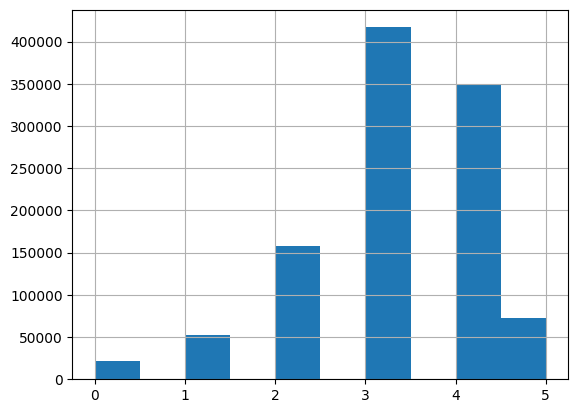

In [15]:
data[' rating'].astype('int').hist()

In [68]:
df = data.copy()

In [69]:
from sklearn.preprocessing import OneHotEncoder

df[' openness'] = df[' openness'].astype(object)
df[' agreeableness'] = df[' agreeableness'].astype(object)
df[' emotional_stability'] = df[' emotional_stability'].astype(object)
df[' conscientiousness'] = df[' conscientiousness'].astype(object)
df[' extraversion'] = df[' extraversion'].astype(object)
df[' movie_id'] = df[' movie_id'].astype(object)

In [18]:
# OneHotEncoder

#categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
#encoder = OneHotEncoder(sparse_output=False)
#encoder = encoder.fit(df[categorical_columns])
#ohe = encoder.transform(df[categorical_columns])
#ohe_df = pd.DataFrame(ohe, columns=encoder.get_feature_names_out(categorical_columns))
#df = pd.concat([df, ohe_df], axis=1)
#df = df.drop(categorical_columns, axis=1)

In [19]:
df

,movie_id,rating,openness_1.0,openness_1.5,openness_2.0,openness_2.5,openness_3.0,openness_3.5,openness_4.0,openness_4.5,...,extraversion_2.5,extraversion_3.0,extraversion_3.5,extraversion_4.0,extraversion_4.5,extraversion_5.0,extraversion_5.5,extraversion_6.0,extraversion_6.5,extraversion_7.0
0,1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,6,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070198,95167,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1070199,103335,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1070200,104374,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1070201,107890,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [151]:
X = df.drop(' rating', axis = 1)#.values.astype('float32')
y = df[' rating'].values.astype('int')

In [ ]:
!pip install category_encoders --quiet
import category_encoders as ce

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [152]:
cbe_encoder = ce.cat_boost.CatBoostEncoder()
cbe_encoder.fit(X, y)
X_cbe = cbe_encoder.transform(X)

In [153]:
X = X_cbe.values.astype('float32')

In [108]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=seed, replacement=True)

X, y = rus.fit_resample(X, y)

# NN

## Split data

In [154]:
from sklearn.model_selection import train_test_split

def split_data(X, y, seed=42):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed, stratify=y_train)

  return X_train, y_train, X_val, y_val, X_test, y_test

## Pytorch

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import copy
import numpy as np

In [77]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [155]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

In [35]:
class Data(Dataset):
    def __init__(self, X, y):
        self.x=torch.from_numpy(X)
        self.y=torch.from_numpy(y)
        self.len=self.x.shape[0]
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

Define train dataloader

In [156]:
train_data = Data(X_train, y_train)
train_dl = DataLoader(dataset=train_data, batch_size=32)

Define validate data

In [157]:
val_data = Data(X_val, y_val)
valid_dl = DataLoader(dataset=val_data, batch_size=32)

Define test data

In [158]:
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = y_test


In [169]:
class Model(nn.Module):

    def __init__(self, input_shape, output_shape=6):
        super(Model, self).__init__()

        self.fc1 = nn.Linear(input_shape, 16)
        self.fc2 = nn.Linear(16, 32)
        self.dropout = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, output_shape)

        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.dropout(x)
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        x = self.fc5(x)

        return x


In [170]:
learning_rate = 0.015#1e-3

model = Model(X_train.shape[1], len(set(y)))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# training parameters
n_epochs = 5   # number of epochs to run

# Hold the best model
best_loss = np.inf   # init to infinity
best_weights = None
history_loss = []
history_acc = []
history_val_loss = []
history_val_acc = []

total_params = sum(p.numel() for p in model.parameters())
params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Trainable params count: {params_trainable }')
print(f'Total params count: {total_params}')

Trainable params count: 11862
Total params count: 11862


In [171]:
# training loop
for epoch in range(n_epochs):
  print(f'Epoch {epoch}')
  model.train()
  for X_train, y_train in tqdm(train_dl):

    # forward pass
    y_pred = model(X_train)

    # calculate loss
    loss = criterion(y_pred, y_train)

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # update weights
    optimizer.step()

  # calculate accuracy
  acc = (torch.argmax(y_pred, 1) == y_train).float().mean()
  history_acc.append(acc)

  print(f'Train Loss: {loss} | Accuracy: {acc}')
  history_loss.append(float(loss))

  # evaluate
  model.eval()
  loss_val = 0
  acc_val = 0

  with torch.no_grad():
    for X_val, y_val in valid_dl:
      pred_val = model(X_val)
      loss_val += criterion(pred_val, y_val)
      acc_val += (torch.argmax(pred_val, 1) == y_val).float().mean()

    # calculate valid loss, acc
    loss_val /= len(valid_dl)
    acc_val /= len(valid_dl)
    history_val_loss.append(loss_val)
    history_val_acc.append(acc_val)

    print(f'Validate Loss: {loss_val} | Accuracy: {acc_val}')
    print('-'*30)

    # store best model
    if loss_val < best_loss:
      best_loss = loss_val
      best_model_wts = copy.deepcopy(model.state_dict())

Epoch 0


100%|██████████| 20067/20067 [00:58<00:00, 340.39it/s]


Train Loss: 1.3828779458999634 | Accuracy: 0.4444444477558136
Validate Loss: 1.4265191555023193 | Accuracy: 0.3895292580127716
------------------------------
Epoch 1


100%|██████████| 20067/20067 [00:59<00:00, 335.00it/s]


Train Loss: 1.3828779458999634 | Accuracy: 0.4444444477558136
Validate Loss: 1.4265191555023193 | Accuracy: 0.3895292580127716
------------------------------
Epoch 2


100%|██████████| 20067/20067 [01:04<00:00, 309.74it/s]


Train Loss: 1.3828779458999634 | Accuracy: 0.4444444477558136
Validate Loss: 1.4265191555023193 | Accuracy: 0.3895292580127716
------------------------------
Epoch 3


100%|██████████| 20067/20067 [01:10<00:00, 284.08it/s]


Train Loss: 1.3828779458999634 | Accuracy: 0.4444444477558136
Validate Loss: 1.4265191555023193 | Accuracy: 0.3895292580127716
------------------------------
Epoch 4


100%|██████████| 20067/20067 [01:13<00:00, 271.80it/s]


Train Loss: 1.3828779458999634 | Accuracy: 0.4444444477558136
Validate Loss: 1.4265191555023193 | Accuracy: 0.3895292580127716
------------------------------


In [115]:
from matplotlib import pyplot as plt

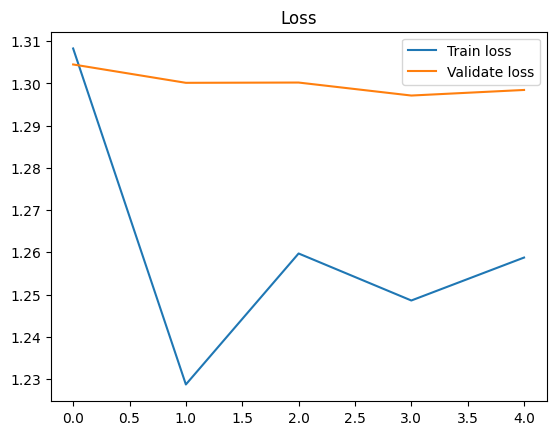

In [161]:
plt.plot(history_loss)
plt.plot(history_val_loss)
plt.legend(['Train loss', 'Validate loss'])
plt.title('Loss')
plt.show()


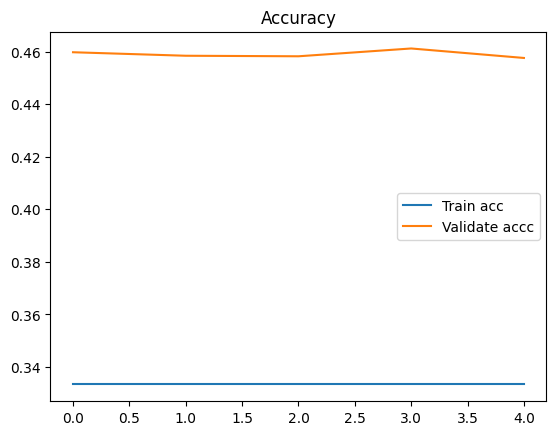

In [162]:
plt.plot(history_acc)
plt.plot(history_val_acc)
plt.legend(['Train acc', 'Validate accc'])
plt.title('Accuracy')
plt.show()


In [163]:
model.load_state_dict(best_model_wts)
model.eval()
y_pred = model(X_test)
_, y_pred = torch.max(y_pred.data, 1)
y_pred = y_pred.cpu().numpy()

In [164]:
set(y_pred)

{0, 1, 2, 3, 4}

In [165]:
y_pred

array([3, 3, 4, ..., 3, 3, 3])

In [166]:
y_test

array([3, 0, 4, ..., 3, 2, 3])

In [106]:
from sklearn.metrics import f1_score

In [167]:
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f'Macro: {f1_macro}')
print(f'Micro: {f1_micro}')
print(f'Weighted: {f1_weighted}')
print(f'Accuracy: {(y_test == y_pred).mean()}')

Macro: 0.22792971595620357
Micro: 0.46242075116449655
Weighted: 0.4172535656150864
Accuracy: 0.46242075116449655
